# Stable Diffusion on a CPU

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/model-inference/stable-diffusion/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=model-inference/stable-diffusion/index.ipynb)

[Stable Diffusion](https://github.com/CompVis/stable-diffusion) is a state of the art text-to-image model that generates images from text and was developed as an open source alternative to [DALL·E 2](https://openai.com/dall-e-2/). It is based on a [Diffusion Probabilistic Model](https://arxiv.org/abs/2102.09672) and uses a [Transformer](https://arxiv.org/abs/1706.03762) to generate images from text.

This example demonstrates how to use stable diffusion on a CPU and run it on the [Bacalhau](https://www.bacalhau.org/) network. The first section describes the development of the code and the container. The section section demonstrates how to run the job using [Bacalhau](https://www.bacalhau.org/).

The following image is an example generated by this model.

### TL;DR

```bash
bacalhau docker run ghcr.io/bacalhau-project/examples/stable-diffusion-cpu:0.0.1 -- python demo.py --prompt "cod in space" --output ../outputs/cod.png
```

![](cod.png)



## 1. Development

The [original](https://github.com/CompVis/stable-diffusion) text-to-image stable diffusion model was trained on a fleet of GPU machines, at great cost. To use this trained model for inference, you also need to run it on a GPU.

However, this isn't always desired or possible. One alternative is to use a project called [OpenVINO](https://docs.openvino.ai/latest/index.html) from Intel that allows you to convert and optimise models from a variety of frameworks (and ONNX if your framework isn't directly supported) to run on a [supported](https://docs.openvino.ai/latest/openvino_docs_OV_UG_Working_with_devices.html) Intel CPU. This is what we will do in this example.

:::tip
Heads up! This example takes about 10 minutes to generate an image on an average CPU. Whilst this demonstrates it is possible, it might not be practical.
:::

### Prerequisites

In order to run this example you need:

* A Debian-flavoured Linux (although you [might be able](https://github.com/bfirsh/stable-diffusion/tree/apple-silicon-mps-support) to get it working on M1 macs)
* [Docker](https://docs.docker.com/get-docker/)


### Converting Stable Diffusion to a CPU Model Using OpenVINO

The first step is to convert the trained stable diffusion models so that they work efficiently on a CPU using OpenVINO. The example is quite complex, so we have created a [separate repository](https://github.com/js-ts/stable_diffusion.openvino) (which is a fork from Github user [Sergei Belousov](https://github.com/bes-dev/stable_diffusion.openvino)) to host the code. In summary, the code:

* Downloads a [pre-optimized OpenVINO version](https://huggingface.co/bes-dev/stable-diffusion-v1-4-openvino) of ...
* the [original](https://huggingface.co/CompVis/stable-diffusion-v1-4) pre-trained stable diffusion model ...
* which also leverages OpenAI's [CLIP transformer](https://huggingface.co/openai/clip-vit-large-patch14) ...
* and is then wrapped inside an OpenVINO runtime, which reads in and executes the model.

The core code representing these tasks can be found [in the `stable_diffusion_engine.py` file](https://github.com/js-ts/stable_diffusion.openvino/blob/master/stable_diffusion_engine.py). This is a mashup that creates a pipeline necessary to tokenize the text and run the stable diffusion model. This boilerplate could be simplified by leveraging the more recent version of the [diffusers library](https://github.com/huggingface/diffusers). But let's crack on.

### Install Dependencies

Note that these dependencies are only known to work on Ubuntu-based x64 machines.

In [5]:
%%bash
sudo apt-get update
sudo apt-get install -y libgl1 libglib2.0-0 git-lfs

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,550 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:1

### Clone the Repository and Dependencies

The following commands clone the example repository, other required repositories, and installs the Python dependencies.

In [6]:
%%bash
git clone https://github.com/js-ts/stable_diffusion.openvino
cd stable_diffusion.openvino
git lfs install
git clone https://huggingface.co/openai/clip-vit-large-patch14
git clone https://huggingface.co/bes-dev/stable-diffusion-v1-4-openvino
pip3 install -r requirements.txt

Updated git hooks.
Git LFS initialized.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=26590051d891b62435bf2dacfe6f7892c2f6d31effc4d2bb29b64745dc2db715
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=d7d5bb4237a42691e3802c2eae97905bfafd668e1bec67a4fba4420dc7e4fef7
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built validators sacremoses
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled t

fatal: destination path 'stable_diffusion.openvino' already exists and is not an empty directory.
fatal: destination path 'clip-vit-large-patch14' already exists and is not an empty directory.
Cloning into 'stable-diffusion-v1-4-openvino'...
tcmalloc: large alloc 1471086592 bytes == 0x557fcdf96000 @  0x7fbf33db52a4 0x557f9119511f 0x557f9117225b 0x557f91126f33 0x557f910cb22a 0x557f910cb6e6 0x557f910e8451 0x557f910e89e9 0x557f910e8f13 0x557f9118de12 0x557f9102f162 0x557f91015a65 0x557f91016725 0x557f9101572a 0x7fbf330fcc87 0x557f9101577a
tcmalloc: large alloc 2206621696 bytes == 0x558025a86000 @  0x7fbf33db52a4 0x557f9119511f 0x557f9117225b 0x557f91126f33 0x557f910cb22a 0x557f910cb6e6 0x557f910e8451 0x557f910e89e9 0x557f910e8f13 0x557f9118de12 0x557f9102f162 0x557f91015a65 0x557f91016725 0x557f9101572a 0x7fbf330fcc87 0x557f9101577a
tcmalloc: large alloc 3309936640 bytes == 0x5580a92ec000 @  0x7fbf33db52a4 0x557f9119511f 0x557f9117225b 0x557f91126f33 0x557f910cb22a 0x557f910cb6e6 0x557f91

### Generating an Image

Now that we have all the dependencies installed, we can call the `demo.py` wrapper, which is a simple CLI, to generate an image from a prompt.

In [8]:
!cd stable_diffusion.openvino && \
  python3 demo.py --prompt "hello" --output hello.png

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
tcmalloc: large alloc 3438092288 bytes == 0x31ba6000 @  0x7f97fabbd1e7 0x7f97e8f5d3f6 0x7f97e8c241e3 0x7f975be0f944 0x7f97e90ec49c 0x7f97e8d4e6e5 0x7f97e8cb9305 0x7f97e963a95e 0x7f97e966ad0e 0x58ec54 0x58fc01 0x51b7fd 0x5b41c5 0x4ba80a 0x537e46 0x58ff66 0x51bbc5 0x58f2a7 0x51740e 0x5b41c5 0x604133 0x606e06 0x606ecc 0x609aa6 0x64d332 0x64d4de 0x7f97fa7bac87 0x5b561a
32it [11:09, 20.92s/it]


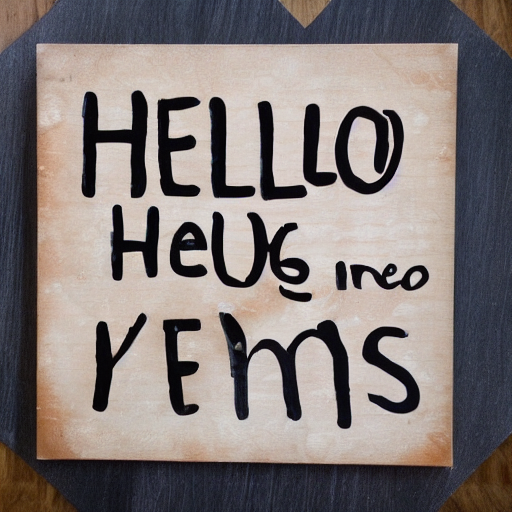

In [10]:
import IPython.display as display
display.Image("stable_diffusion.openvino/hello.png")

In [12]:
!cd stable_diffusion.openvino && \
  python3 demo.py --prompt "cat driving a car" --output cat.png

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
tcmalloc: large alloc 3438092288 bytes == 0x3202e000 @  0x7fac3f2091e7 0x7fac2d5a93f6 0x7fac2d2701e3 0x7faba045b944 0x7fac2d73849c 0x7fac2d39a6e5 0x7fac2d305305 0x7fac2dc8695e 0x7fac2dcb6d0e 0x58ec54 0x58fc01 0x51b7fd 0x5b41c5 0x4ba80a 0x537e46 0x58ff66 0x51bbc5 0x58f2a7 0x51740e 0x5b41c5 0x604133 0x606e06 0x606ecc 0x609aa6 0x64d332 0x64d4de 0x7fac3ee06c87 0x5b561a
32it [11:13, 21.06s/it]


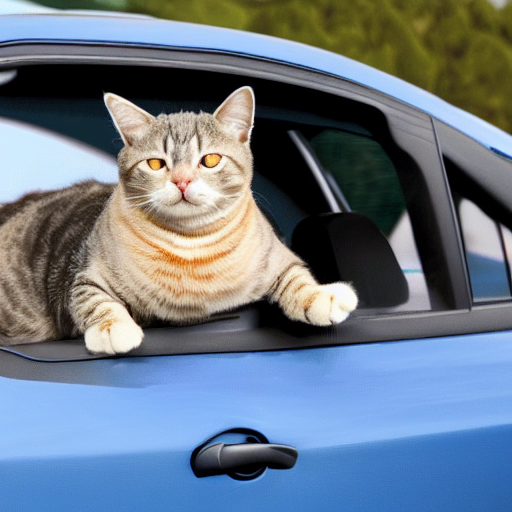

In [13]:
import IPython.display as display
display.Image("stable_diffusion.openvino/cat.png")

## 2. Running Stable Diffusion (CPU) on Bacalhau

Now we have a working example, we can convert it into a format that allows us to perform inference in a distributed environment.

First we will create a `Dockerfile` to containerize the inference code. The Dockerfile [can be found in the repository](https://github.com/js-ts/stable_diffusion.openvino/blob/master/Dockerfile), but is presented here to aid understanding.

```Dockerfile
FROM python:3.9.9-bullseye

WORKDIR /src

RUN apt-get update && \
    apt-get install -y \
    libgl1 libglib2.0-0 git-lfs

RUN git lfs install

COPY requirements.txt /src/

RUN pip3 install -r requirements.txt

COPY stable_diffusion_engine.py demo.py demo_web.py /src/
COPY data/ /src/data/

RUN git clone https://huggingface.co/openai/clip-vit-large-patch14
RUN git clone https://huggingface.co/bes-dev/stable-diffusion-v1-4-openvino

# download models
RUN python3 demo.py --num-inference-steps 1 --prompt "test" --output /tmp/test.jpg
```

This container is using the `python:3.9.9-bullseye` image and the working directory is set. Next the Dockerfile installs the same dependencies from earlier in this notebook. Then we add our custom code and pull the dependent repositories.

We've already pushed this image to GHCR, but for posterity, you'd use a command like this to update it:

```bash
docker buildx build --platform linux/amd64 --push -t ghcr.io/bacalhau-project/examples/stable-diffusion-cpu:0.0.1 .
```

### Prerequisites

To run this example you will need:

* [Bacalhau](https://www.bacalhau.org/) installed and running

In [1]:
!command -v bacalhau >/dev/null 2>&1 || (export BACALHAU_INSTALL_DIR=.; curl -sL https://get.bacalhau.org/install.sh | bash)
path=!echo $PATH
%env PATH=./:{path[0]}

env: PATH=./:/Users/phil/.pyenv/versions/3.9.7/bin:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/Users/phil/.gvm/bin:/opt/homebrew/opt/findutils/libexec/gnubin:/opt/homebrew/opt/coreutils/libexec/gnubin:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/Users/phil/.pyenv/shims:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/usr/local/MacGPG2/bin:/Users/phil/.nexustools


### Generating an Image Using Stable Diffusion on Bacalhau

[Bacalhau](https://www.bacalhau.org/) is a distributed computing platform that allows you to run jobs on a network of computers. It is designed to be easy to use and to run on a variety of hardware. In this example, we will use it to run the stable diffusion model on a CPU.

To submit a job, you can use the Bacalhau CLI. The following command passes a prompt to the model and generates an image in the outputs directory.

:::tip

This will take about 10 minutes to complete. Go grab a coffee. Or a beer. Or both. If you want to block and wait for the job to complete, add the `--wait` flag.

Furthermore, the container itself is about 15GB, so it might take a while to download on the node if it isn't cached.

:::

In [2]:
%%bash --out job_id
bacalhau docker run ghcr.io/bacalhau-project/examples/stable-diffusion-cpu:0.0.1 --id-only -- python demo.py --prompt "First Humans On Mars" --output ../outputs/mars.png

In [3]:
%env JOB_ID={job_id}

env: JOB_ID=ff7b104d-0736-434e-8e5f-dc47c457cbf5



Running the commands will output a UUID that represents the job that was created. You can check the status of the job with the following command:


In [4]:
%%bash
bacalhau list --id-filter ${JOB_ID}

 CREATED   ID        JOB                      STATE      VERIFIED  PUBLISHED               
 14:14:05  ff7b104d  Docker jsacex/stable...  Completed            /ipfs/QmWxg6CXqZhjAa... 



Wait until it says `Completed` and then get the results.

To find out more information about your job, run the following command:

In [5]:
%%bash
bacalhau describe ${JOB_ID}

APIVersion: V1alpha1
ClientID: 77cf46c04f88ffb1c3e0e4b6e443724e8d2d87074d088ef1a6294a448fa85d2e
CreatedAt: "2022-10-13T14:14:05.447388688Z"
Deal:
  Concurrency: 1
ExecutionPlan:
  ShardsTotal: 1
ID: ff7b104d-0736-434e-8e5f-dc47c457cbf5
JobState:
  Nodes:
    QmYgxZiySj3MRkwLSL4X2MF5F9f2PMhAE3LV49XkfNL1o3:
      Shards:
        "0":
          NodeId: QmYgxZiySj3MRkwLSL4X2MF5F9f2PMhAE3LV49XkfNL1o3
          PublishedResults:
            CID: QmWxg6CXqZhjAagQVxqopwhyXMHAHvTFKXYtWjzc7BJp65
            Name: job-ff7b104d-0736-434e-8e5f-dc47c457cbf5-shard-0-host-QmYgxZiySj3MRkwLSL4X2MF5F9f2PMhAE3LV49XkfNL1o3
            StorageSource: IPFS
          RunOutput:
            exitCode: 0
            runnerError: ""
            stderr: "ftfy or spacy is not installed using BERT BasicTokenizer instead
              of ftfy.\n\r0it [00:00, ?it/s]\r1it [00:05,  5.26s/it]\r2it [00:09,
              \ 4.95s/it]\r3it [00:14,  4.96s/it]\r4it [00:19,  4.84s/it]\r5it [00:24,
              \ 4.92s/it]\r6it

If you see that the job has completed and there are no errors, then you can download the results with the following command:

In [6]:
%%bash
rm -rf results && mkdir -p results
bacalhau get $JOB_ID --output-dir results

Fetching results of job 'ff7b104d-0736-434e-8e5f-dc47c457cbf5'...

After the download has finished you should 
see the following contents in results directory:

In [8]:
%%bash
ls results/volumes/outputs

mars.png


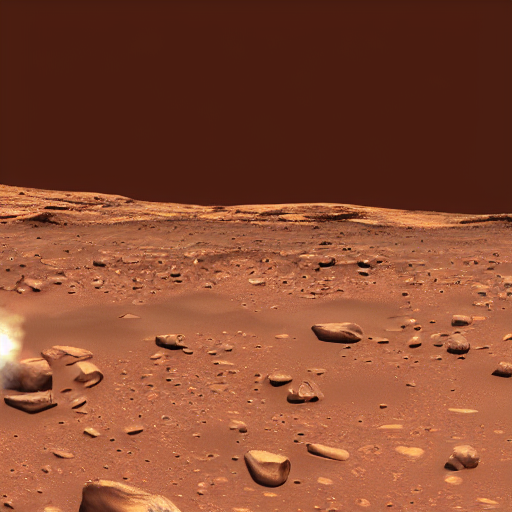

In [9]:
import IPython.display as display
display.Image("results/volumes/outputs/mars.png")